In [1]:
import numpy as np

from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

## Funciones

Funciones de costo para calcular el error.

In [2]:
def error_cuadrático_medio(objetivo, predicción):
    return np.mean( (objetivo - predicción)**2 ) / 2

Funciones de activación con sus derivadas. Son generadores que se inicializan con los parámetros de la función, devuelven la función y su derivada, ambas deben aceptar como argumento un arreglo de Numpy.

In [3]:
def escalón():
    f = lambda x: np.piecewise(x, [x < 0, x >= 0], [0, 1])
    d = lambda x: 1
    
    return f, d


def identidad():
    f = lambda x: x
    d = lambda x: 1
    
    return f, d


def relu():
    f = lambda x: np.maximum(0, x)
    d = lambda x: np.piecewise(x, [x <= 0, x > 0], [0, 1])

    return f, d


# leaky ReLU, la derivada para x <= 0 no es nula sino un valor pequeño
def lrelu():
    f = lambda x: np.maximum(0, x)
    d = lambda x: np.piecewise(x, [x <= 0, x > 0], [0.01, 1])

    return f, d


def logística():
    f = lambda x: 1 / (1 + np.exp(-x))
    d = lambda x: f(x) * (1 - f(x))

    return f, d


def tanh():
    f = np.tanh
    d = lambda x: 1 - f(x)**2
    
    return f, d

## Elementos de la red

Una **capa** se define en base a cierta cantidad de unidades con una función de activación.

En la **propagación** el parámetro `i` representa el valor de entrada a las unidades y el parámetro `o`, el de salida. Cabe notar que a la salida se le agrega el bias de la capa. El bias es _virtual_, no está representado como unidad.

```
    entrada    función activación    salida
                                     | o0 | = 1 (BIAS)
    | i1 |                           | o1 |
    | i2 | --> f(i) ---------------> | o2 |
    | i3 |                           | o3 |
```

Cuando consideramos la **retropropagación** del error, el sentido inverso utiliza los parámetros `ei` y `eo` para los errores que entran a y salen de la capa, respectivamente.

```
    salida     derivada activación   entrada
                                     | ei0 | = 1 (BIAS)
    | eo1 |                          | ei1 |
    | eo2 | <- f'(i) · ei <--------- | ei2 |
    | eo3 |                          | ei3 |
```

In [4]:
class Capa:
    
    def __init__(self, activación, unidades):
        self.función, self.derivada = activación()
        self.unidades = unidades
        self.feeds = []
        self.backs = []
        
        
    def propagar(self):
        Y = self.función(self.i)
        self.o = np.insert(Y, 0, 1., axis=1) # agregar vector columna de bias
        
        for sinapsis in self.feeds: sinapsis.propagar()

            
    def retropropagar(self, eta, mu):
        E = np.delete(self.ei, 0, axis=1) # remover vector columna de bias
        self.eo = E * self.derivada(self.i)
        
        for sinapsis in self.backs: sinapsis.retropropagar(eta, mu)
        
        
    def estado(self):
        return np.delete(self.o, 0, axis=1) # remover vector columna de bias
    
    
    def error(self, E):
        self.ei = np.insert(E, 0, 1., axis=1) # agregar vector columna de bias

Las capas se comunican mediante **sinapsis**. Una sinapsis tiene una capa de _origen_ y una de _destino_, a su vez guarda los pesos de las conexiones entre unidades.

Los elementos de la red están pensados para tratar a las muestas como *vectores filas*. En un arreglo bidimensional de varias muestras, cada fila es una muestra y las columnas del arreglo son los distintos atributos. En la bibliografía se suele observar otro camino: las muestras son *vectores columnas*; quizás sea más sencillo para hacer/interpretar cuentas. En la práctica, encontramos a los vectores filas más a tono con la forma de los conjuntos de datos (pensar en un archivo CSV o en una tabla de una base de datos).

```
    filas    = dim(origen) + 1 (BIAS)
    columnas = dim(destino)
    
    W =  | b00  b01 |  matriz de pesos de una sinapsis que conecta una capa de 3 unidades (origen) con otra de 2 (destino)
         | w10  w11 |  la primera fila corresponde a los pesos del bias
         | w20  w21 |
         | w30  w31 |
         
    Y =  | 1  a1  a2  a3 |  actividad de salida de la capa de origen, 2 muestras con 3 atributos y bias (primera columna)
         | 1  b1  b2  b3 |
         
    Z =  Y · W =  | a'1  a'2 |  la actividad de entrada a la capa de destino entonces se calcula
                  | b'1  b'2 |  como el producto interno entre la salida (Y) y los pesos (W)
```

In [5]:
class Sinapsis:
  
    def __init__(self, origen, destino, inicialización):
        self.origen  = origen
        self.destino = destino
        
        forma        = (origen.unidades + 1, destino.unidades)
        
        self.V_prev  = np.zeros(forma)
        self.V       = np.zeros(forma)
        self.W       = np.random.uniform(low=inicialización[0], high=inicialización[1], size=forma)
        
        
    def propagar(self):
        Y = self.origen.o # actividad de la capa anterior
        self.destino.i = np.dot(Y, self.W)
        
    
    def retropropagar(self, eta, mu):
        E = self.destino.eo # error de la capa posterior        
        self.origen.ei = np.dot(E, self.W.T)
        self.ajustar_pesos(eta, mu)
        
          
    def ajustar_pesos(self, eta, mu):
        """http://cs231n.github.io/neural-networks-3/
        
        Momento
        v = mu * v - learning_rate * dx    # integrate velocity
        x += v                             # integrate position

        Momento de Nesterov
        v_prev = v                         # back this up
        v = mu * v - learning_rate * dx    # velocity update stays the same
        x += -mu * v_prev + (1 + mu) * v   # position update changes form

        Recommended annealing schedules for mu: 0.5, 0.9, 0.95, 0.99
        """
        
        Y = self.origen.o # actividad de la capa anterior
        E = self.destino.eo # error de la capa posterior
        
        self.V_prev = self.V
        self.V = mu * self.V - eta * np.dot(Y.T, E) / E.shape[0] # se promedia por el tamaño del lote
        self.W += -mu * self.V_prev + (1 + mu) * self.V

Las siguientes funciones se utilizan durante el entrenamiento.

In [6]:
def lotes(X, y, n):
    if n < 1: n = len(X)
    
    for i in range(0, len(X), n):
        yield X[i:i+n], y[i:i+n]

        
def barajar(X, y):
    e = np.random.get_state()
    X = np.random.permutation(X)
    np.random.set_state(e)
    y = np.random.permutation(y)
    
    return X, y


def graficar(evolución_error, c='b'):
    p, = plt.plot(evolución_error, c=c)
    plt.yscale('log')
    plt.xlabel('épocas')
    plt.ylabel('error')
    return p

In [44]:
import serial
s = serial.Serial('/dev/ttyUSB0', 9600)

In [46]:
import time

def arduino(s):
    global eta, señal
    señal = True
    
    while señal:
        eta = round(int(s.readline()) / 1023, 3)

In [47]:
import threading

t = threading.Thread(target=arduino, args=(s,))
t.start()

In [ ]:
señal = False
s.close()

In [173]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import binarize
import copy

class Red(BaseEstimator):

    def __init__(self, activación=logística, inicialización=(-.5,.5), capas_ocultas=(),
                 épocas=1000, tolerancia=1e-5, lote=10,
                 aprendizaje=.5, momento=.5, adaptación=0, 
                 early_stopping=False,
                 validación=False, graficar=False):
        
        self.activación     = activación
        self.inicialización = inicialización
        self.capas_ocultas  = capas_ocultas
        
        self.épocas     = épocas
        self.tolerancia = tolerancia
        self.lote       = lote
        
        self.aprendizaje = aprendizaje
        self.momento     = momento
        self.adaptación  = adaptación
        
        self.early_stopping = early_stopping
            
        self.validación = validación
        self.graficar = graficar
        
    
    def _inicializar(self, n_entradas, n_salidas):
        self.capas    = OrderedDict()
        self.sinapsis = OrderedDict()
        
        # instanciación de capas
        self.capas['entrada'] = Capa(identidad, n_entradas)
        
        for i, n_unidades in enumerate(self.capas_ocultas):
            id_capa = 'oculta_%s' % (i + 1)
            self.capas[id_capa] = Capa(self.activación, n_unidades)
        
        self.capas['salida'] = Capa(identidad, n_salidas)
        
        # se asume que la red es feed-forward
        ids_capas  = list(self.capas.keys())
        conexiones = [(capa_origen, capa_destino, self.inicialización) for capa_origen, capa_destino in zip(ids_capas, ids_capas[1:])]
            
        # instanciación de sinapsis
        for (id_origen, id_destino, inicialización) in conexiones:
            origen   = self.capas[id_origen]
            destino  = self.capas[id_destino]
            
            sinapsis = self.sinapsis[(id_origen, id_destino)] = Sinapsis(origen, destino, inicialización)
            
            origen.feeds.append(sinapsis)
            destino.backs.append(sinapsis)        
    

    def fit(self, X, y):
        global eta

        # asegurarse de que 'y' sea 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        
        n_entradas = X.shape[1]
        n_salidas  = y.shape[1]
        
        self._inicializar(n_entradas, n_salidas)
        
        self.evolución_error = []
        self.evolución_validación = []
        self.convergencia = False
        
        if self.validación:
            X, X_val, y, y_val = train_test_split(X, y, test_size=0.3)

        if self.graficar:
            %matplotlib notebook
            fig = plt.figure()
            ax  = fig.add_subplot(111)
        
            plt.yscale('log')
            plt.xlabel('épocas')
            plt.ylabel('error')
            plt.ion()
        
        
        for época in range(self.épocas):            
            eta = self.aprendizaje * np.exp(-self.adaptación * época) 
            
            _X, _y = barajar(X, y)
            
            y_pred = np.concatenate(
                [self._aprender(lote_X, lote_y, eta, self.momento) for lote_X, lote_y in lotes(_X, _y, self.lote)]
            )
            
            error = error_cuadrático_medio(_y, y_pred)
            self.evolución_error.append(error)
            
            if self.validación:
                error_validación = error_cuadrático_medio(y_val, self.predict(X_val))
                self.evolución_validación.append(error_validación)
                
                
            #if self.early_stopping:
            #       
            #    if época > 0 and época % self.épocas_delta == 0 \
            #    and self.evolución_validación[-self.épocas_delta] < error_validación:
            #        
            #        del self.evolución_error[-self.épocas_delta:] # el arreglo tiene un elemento más
            #        del self.evolución_validación[-self.épocas_delta+1:]
            #        self.sinapsis = self.foto
            #        break
            
            if self.graficar and época % 25 == 0:
                e = ax.plot(self.evolución_error, c='b')
                
                if self.validación:
                    v = ax.plot(self.evolución_validación, c='g')
    
                ax.set_xlim([época-500, época])
                ax.set_ylim([1e-6, 10])
            
                #plt.legend([v, e], ['validación', 'entrenamiento'])
            
                ax.set_title('n = %s | µ = %s' % (eta, self.momento))
                fig.canvas.draw()
                
            if error <= self.tolerancia:
                self.convergencia = True
                break
                
            #if self.épocas_delta > 0 and época % self.épocas_delta == 0:
            #    self.foto = copy.deepcopy(self.sinapsis)
        
        return self
       
                 
    def _aprender(self, X, y_obj, eta, mu):
        y_pred = self.predict(X)
        
        self.capas['salida'].error(y_pred - y_obj) 
        
        for _, capa in reversed(self.capas.items()): capa.retropropagar(eta, mu)
        
        return y_pred
        
    
    def predict(self, X):
        self.capas['entrada'].i = X
        
        for _, capa in self.capas.items(): capa.propagar()
        
        return self.capas['salida'].estado()

    
class Clasificador(Red):
        
    def score(self, X, y):
        #return accuracy_score(y, binarize(self.predict(X), threshold=0.5))
        return f1_score(y, binarize(self.predict(X), threshold=0.5))
    
    
class Regresor(Red):
   
    def score(self, X, y):
        return -error_cuadrático_medio(y, self.predict(X))

## Pruebas

In [229]:
X = np.array([[1, 1],
              [1, 0],
              [0, 1],
              [0, 0]])

y = np.array([[1, 1, 0],
              [0, 1, 1],
              [0, 1, 1],
              [0, 0, 0]])

<IPython.core.display.Javascript object>


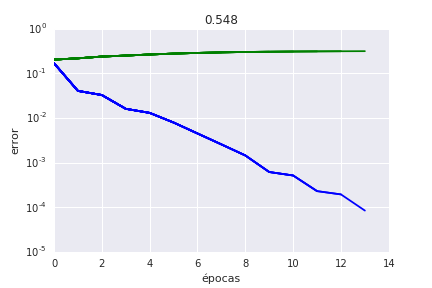

In [269]:
rn = Red().fit(X, y)
#print('convergencia', rn.convergencia)
#graficar(rn.evolución_error)
#plt.savefig('error.png')

## Experimentos

In [147]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import LabelBinarizer
from sklearn.pipeline        import make_pipeline

tp1 = 'tp1_ej1_training.csv'
tp2 = 'tp1_ej2_training.csv'

X_tp1 = np.loadtxt(tp1, dtype='float', delimiter=',', usecols=range(1,10))
y_tp1 = np.loadtxt(tp1, dtype='str',   delimiter=',', usecols=(0,))

X_tp2 = np.loadtxt(tp2, delimiter=',', usecols=(0,1,2,3,4,5))
y_tp2 = np.loadtxt(tp2, delimiter=',', usecols=(6,7))

# transforma las etiquetas 'B' y 'M' a ceros y unos
binarizer = LabelBinarizer()
y_tp1 = binarizer.fit_transform(y_tp1)

# partición del conjunto de datos en conjuntos de entrenamiento (70%) y prueba (30%)
X1_train, X1_test, y1_train, y1_test = train_test_split(X_tp1, y_tp1, test_size=0.25, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_tp2, y_tp2, test_size=0.25, random_state=42)

In [351]:
# transformación de los datos: se remueve la media y se lleva la varianza a la unidad
# en base a las propiedades del conjunto de entrenamiento

#scaler = StandardScaler()

#rn = Red(capas_ocultas=[9], tamaño_lote=10, factor_aprendizaje=.35, épocas=3000)

#clf = make_pipeline(scaler, rn)
#clf.fit(X_train, y_train)

#print('efectividad', clf.score(X_test, y_test))
#print('error', rn.evolución_error[-1])
#print('épocas', len(rn.evolución_error))
#print('convergencia', rn.convergencia)
#graficar(rn.evolución_error)

* capas
* unidades
* función de activación
* hiperparámetros adaptativos
* estocástico/batch/mini-batch
* eta / mu (incluyendo mu nulo)
* preprocesamiento
* early-stopping

estocástico + fit agresivo (eta, mu ~ 1) suele explotar

muchas unidades implica cuidar la inicialización de los pesos porque explotan

como los resultados van entre 0 y 1 se escogió logística y relu. relu no da buenos resultados. 

### Grid search

In [111]:
from sklearn.model_selection import GridSearchCV

estimador = make_pipeline(StandardScaler(), Clasificador())

grilla = {       
        'clasificador__activación': [logística, relu],
    'clasificador__inicialización': [(-.5,.5), (.01,.5)],
     'clasificador__capas_ocultas': [(10,), (14,6), (6,6), (12,6,3)],
              'clasificador__lote': [-1, 1, 10],
       'clasificador__aprendizaje': [.9, .5, .1, .01],
           'clasificador__momento': [.9, .5, .1, 0]
}

In [116]:
np.seterr(all='raise')
clf = GridSearchCV(estimador, grilla, cv=3, n_jobs=3, error_score=0)
clf.fit(X_train, y_train)

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:252: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
FloatingPointError('overflow encountered in exp',)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:252: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
FloatingPointError('overflow encountered in exp',)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site

GridSearchCV(cv=3, error_score=0,
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clasificador', Clasificador(activación=<function logística at 0x7f13db26bf28>, adaptación=0,
       aprendizaje=0.5, capas_ocultas=(), early_stopping=False,
       graficar=False, inicialización=(-0.5, 0.5), lote=10, momento=0.5,
       tolerancia=1e-05, validación=False, épocas=1000))]),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'clasificador__momento': [0.9, 0.5, 0.1, 0], 'clasificador__lote': [-1, 1, 10], 'clasificador__capas_ocultas': [(10,), (14, 6), (6, 6), (12, 6, 3)], 'clasificador__aprendizaje': [0.9, 0.5, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [124]:
clf.best_estimator_.score(X_test, y_test)

0.84210526315789469

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/axis.py:1017: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/axis.py:1027: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


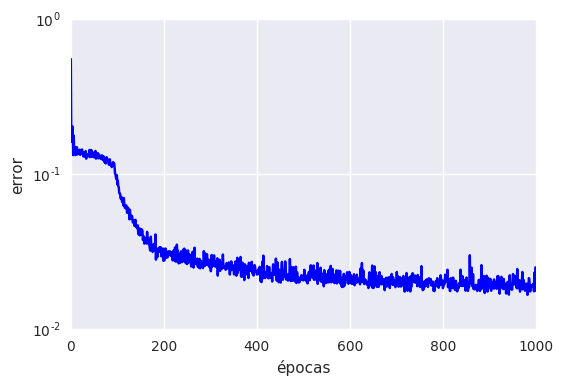

In [119]:
%matplotlib inline
graficar(clf.best_estimator_.named_steps['clasificador'].evolución_error)
#plt.savefig('error_mejor_estimador.png')

In [117]:
import pickle

with open('resultados_ej1.pickle', 'wb') as f:
    pickle.dump(clf.cv_results_, f)

## Early-stopping, momento, hiperparámetros adaptativos

<IPython.core.display.Javascript object>


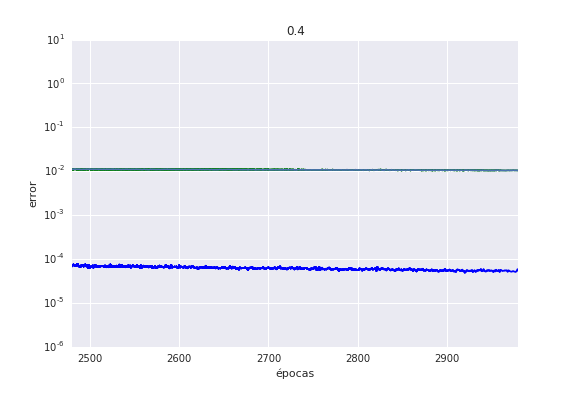

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clasificador', Clasificador(activación=<function logística at 0x7f8650e00c80>,
       aprendizaje=0.4, capas_ocultas=[12, 6, 3], early_stopping=False,
       inicialización=(-0.5, 0.5), momento=0.5, tamaño_lote=10,
       tolerancia=1e-06, épocas=3000))])

In [78]:
pipe = make_pipeline(StandardScaler(), Clasificador(épocas=3000, tolerancia=1e-6, capas_ocultas=[12,6,3], aprendizaje=.5, momento=.5, activación=logística, tamaño_lote=10, inicialización=(-.5,.5)))
pipe.fit(X_train, y_train)

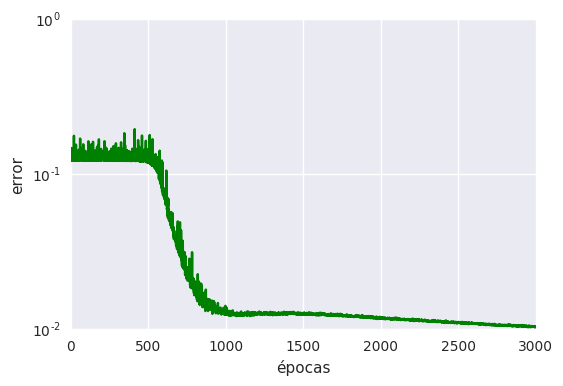

In [87]:
%matplotlib inline
graficar(pipe.steps[1][1].evolución_validación, c='g')

<IPython.core.display.Javascript object>


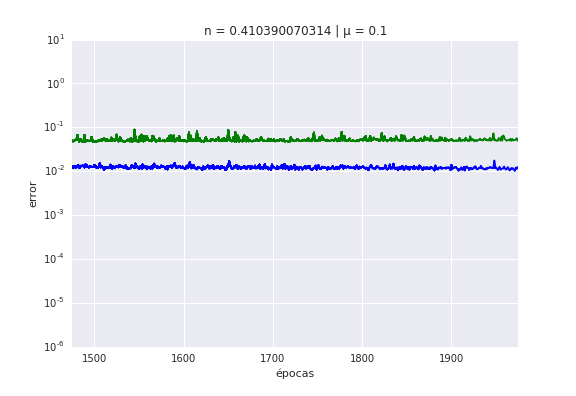

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/axis.py:1017: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/axis.py:1027: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


0.89719626168224298

In [146]:
pipe = make_pipeline(StandardScaler(),
                     Clasificador(épocas=2000,
                                  tolerancia=1e-6,
                                  capas_ocultas=(10,),
                                  graficar=True, validación=True,
                                  adaptación=0.0001, aprendizaje=.5, momento=.1,
                                  activación=logística, lote=10, inicialización=(-.5,.5)))
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

<IPython.core.display.Javascript object>


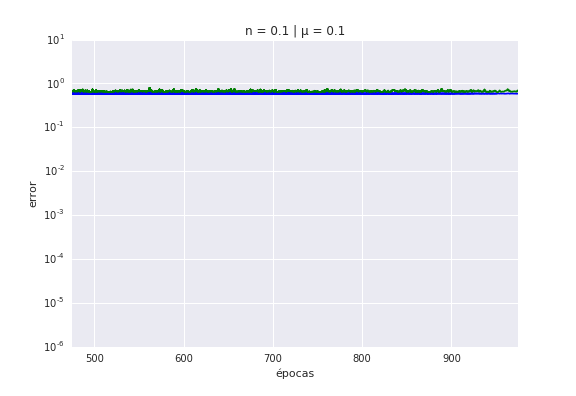

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/axis.py:1017: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/axis.py:1027: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


0.68413632249826095

In [172]:
pipe = make_pipeline(StandardScaler(),
                     Regresor(épocas=1000, tolerancia=1e-6,
                              capas_ocultas=(9,9,9,),
                              graficar=True, validación=True,
                              adaptación=0, aprendizaje=.1, momento=.1,
                              activación=logística, lote=10, inicialización=(-.5,.5)))

pipe.fit(X2_train, y2_train)

pipe.score(X2_test, y2_test)

In [179]:
estimador = make_pipeline(StandardScaler(), Regresor())

grilla = {       
        'regresor__activación': [logística, relu],
    'regresor__inicialización': [(-.5,.5), (.01,.5)],
     'regresor__capas_ocultas': [(9,), (12,6), (6,3), (9,6,3)],
              'regresor__lote': [-1, 1, 10],
       'regresor__aprendizaje': [.9, .5, .1, .01],
           'regresor__momento': [.9, .5, .1, 0]
}

np.seterr(all='raise')
clf2 = GridSearchCV(estimador, grilla, cv=3, n_jobs=3, error_score=-np.inf)
clf2.fit(X2_train, y2_train)

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:252: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FloatingPointError('overflow encountered in exp',)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:252: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FloatingPointError('overflow encountered in exp',)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:252: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FloatingPointError('underflow encountered in exp',)
  "Details: \n%r"

FloatingPointError: invalid value encountered in subtract

In [180]:
clf2.best_estimator_.score(X2_test, y2_test)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'